# Summary statistics + exploratory data analysis
report:
- sample size (by mode/dataset, if needed)
- mapping of distribution of origin/destination of trips
- time of day distribution
- trip distance/travel time distribution
- breakdown by mode

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib
# import seaborn as sns
# import plotly_express as px
import folium
from folium.plugins import HeatMap

In [2]:
# toy data: Jan 2015 citibike data
data = pd.read_csv('data/201501-citibike-tripdata_1.csv')

In [3]:
# read in shapefile of nyc
nyc = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')

In [32]:
# convert time strings to datetime objects
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

# create geodataframe of data
# start points
data_start = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['start station longitude'], data['start station latitude'])).set_crs('EPSG:4326')
# end points
data_end = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['end station longitude'], data['end station latitude'])).set_crs('EPSG:4326')

# set crs of nyc to match data
nyc = nyc.to_crs('EPSG:4326')

In [33]:
# assign census tract information to data
data_start_census = gpd.sjoin(data_start, nyc[["GEOID", "geometry"]], predicate='within', how='left')
data_end_census = gpd.sjoin(data_end, nyc[["GEOID", "geometry"]], predicate='within', how='left')

In [5]:
# sample size
print("n =", len(data))

n = 285552


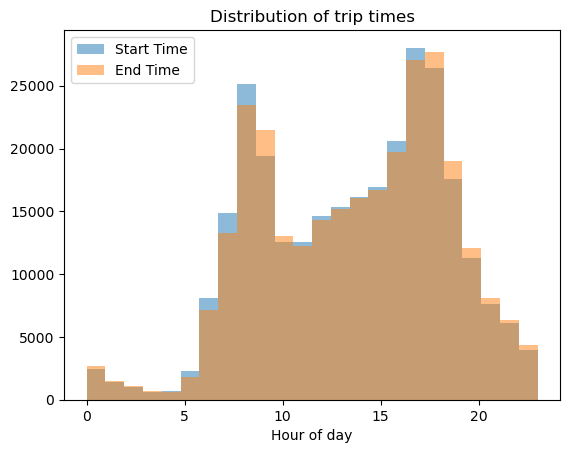

In [21]:
# distribution of start times
plt.hist(data['starttime'].dt.hour, bins=24, alpha=0.5, label='Start Time')
plt.hist(data['stoptime'].dt.hour, bins=24, alpha=0.5, label='End Time')
plt.xlabel('Hour of day')
plt.title('Distribution of trip times')
plt.legend()

Text(0.5, 1.0, 'Distribution of trip times, minutes')

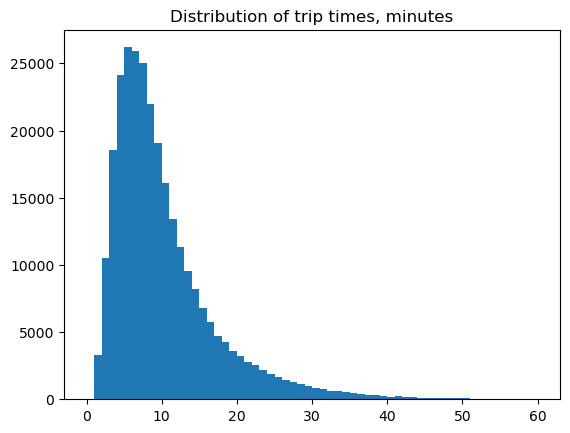

In [13]:
# distribution of travel times
plt.hist(data['tripduration']/60, range=(0,60), bins=60)
plt.title("Distribution of trip times, minutes")

(40.65, 40.85)

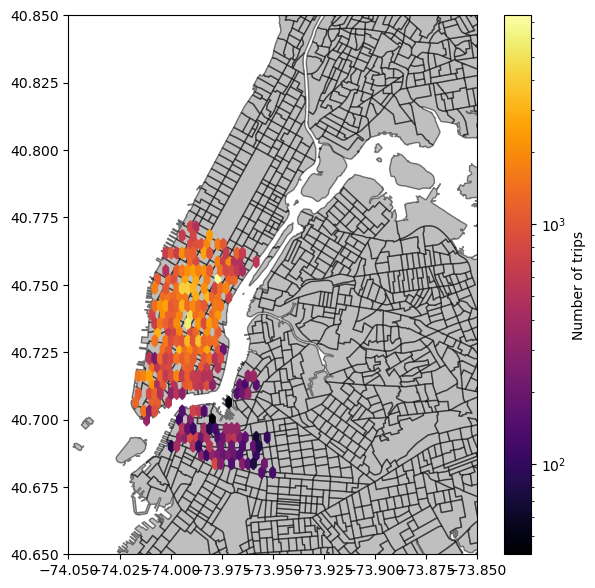

In [56]:
# issues...hex bins look stretched (fix projections)
# bikes only dock at certain stations, data is not continuous-- hex bins aren't the best representation

f, ax = plt.subplots(figsize=(7, 7))
x = data_start['geometry'].x
y = data_start['geometry'].y


nyc.plot(ax=ax, color='grey', alpha=0.5, edgecolor='k')
# hb = ax.hexbin(x, y, gridsize=25, cmap='inferno', mincnt=1)
hb = ax.hexbin(x, y, gridsize=25, cmap='inferno', mincnt=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(hb, label='Number of trips')
# set extent
ax.set_xlim(-74.05, -73.85)
ax.set_ylim(40.65, 40.85)

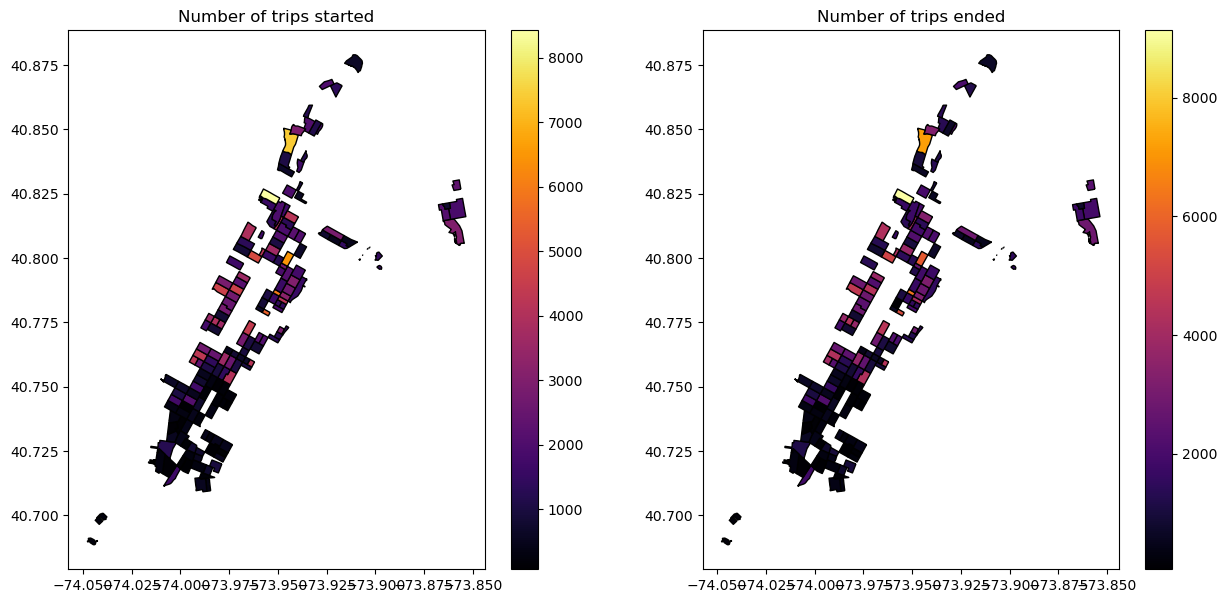

In [78]:
# plot points per census tract, choropleth
nyc["numtrips_start"] = data_start_census.groupby('GEOID').count().tripduration.reset_index().tripduration
nyc["numtrips_end"] = data_end_census.groupby('GEOID').count().tripduration.reset_index().tripduration

f, ax = plt.subplots(1, 2, figsize=(15, 7))
nyc.plot(column='numtrips_start', ax=ax[0], legend=True, cmap='inferno', edgecolor='k')
ax[0].set_title('Number of trips started')
nyc.plot(column='numtrips_end', ax=ax[1], legend=True, cmap='inferno', edgecolor='k')
ax[1].set_title('Number of trips ended')
plt.show()

In [17]:
# try heatmap of start trips instead, plot
# fig = px.density_mapbox(data_start, lat='start station latitude', lon='start station longitude', radius=10, zoom=10, mapbox_style='carto-positron')
# fig.show()

# folium map
m = folium.Map(location=[40.7, -74], zoom_start=12)
hm = HeatMap(data_start[['start station latitude', 'start station longitude']], radius=10).add_to(m)

m


## some research into mining frequent itemsets using python packages
Algorithm: Apriori (or FP growth?)

- MLXtend
- itemset-mining
- apyori
- PyCaret
- MLlib (FP-growth)-- this is what we used in the colab


### note
- do the data processing below in spark instead so we can use `pyspark.ml.fpm`


In [28]:
# combine start and end data, to get start and end census
data_census = pd.concat([data, data_start_census[["GEOID"]].rename(columns={"GEOID":"start_tract"}), data_end_census[["GEOID"]].rename(columns={"GEOID":"end_tract"})], axis=1)

# only keep certain columns
data_subset = data_census[["starttime", "stoptime", "start_tract", "end_tract", "tripduration"]]
data_subset

data_cat = pd.DataFrame()
# make variables categorical for start/stop time and trip duration
# maybe bin by 0-5, 5-15, 15+?
data_cat["tripduration"] = pd.cut(data_subset["tripduration"], bins=[0, 300, 900, np.inf], labels=["0-5", "5-15", "15+"])
# bin by morning peak (7-9), evening peak (4-7), mid-day (10-4), night (8-6)
data_cat["starttime"] = pd.cut(data_subset["starttime"].dt.hour, bins=[0, 7, 10, 16, 19, 24], labels=["offpeak night", "morning peak", "offpeak day", "evening peak", "offpeak night"], ordered=False)
data_cat["stoptime"] = pd.cut(data_subset["stoptime"].dt.hour, bins=[0, 7, 10, 16, 19, 24], labels=["offpeak night", "morning peak", "offpeak day", "evening peak", "offpeak night"], ordered=False)

data_cat["start_tract"] = data_subset["start_tract"]
data_cat["end_tract"] = data_subset["end_tract"]
